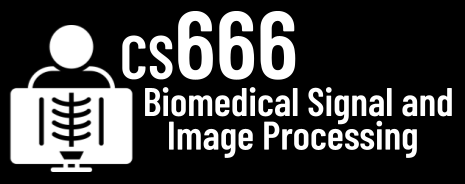
#Assignment 4

In [1]:
# NAME: Lakshmi Keerthana Aravapalli

In [2]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# we are using mahotas again, so lets install it!
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 14.4 MB/s eta 0:00:00


In [5]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [6]:
# Please download this file: https://cs666.org/data/xray/ with the wget command!
# Note: Please use the forwarded dropbox link and change dl=0 to dl=1!
# This is a subset of the Kaggle Pneumonia + Covid Datasets!

In [7]:
!wget https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=1

--2024-04-02 23:30:06--  https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/2ca2889o2ql8n4e/xray.zip [following]
--2024-04-02 23:30:07--  https://www.dropbox.com/s/dl/2ca2889o2ql8n4e/xray.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfc5025e80cbe65bfd5c0880e49.dl.dropboxusercontent.com/cd/0/get/CQQD4P2b4AMoBHj1LZA3BlpHOZckSPI4vY2uyDg7fvuQHAH9WrQzX1JHfpftOF0DPr1NIkA6LG8jx0OqEyVLAPMZqpxdA8KF7lXNVYIOATESlMjDeGJdBMdNn_fnNI0PTjeu8HxgUFCNardqV5llKQJg/file?dl=1# [following]
--2024-04-02 23:30:07--  https://ucfc5025e80cbe65bfd5c0880e49.dl.dropboxusercontent.com/cd/0/get/CQQD4P2b4AMoBHj1LZA3BlpHOZckSPI4vY2uyDg7fvuQHAH9WrQzX1JHfpftOF0DPr1NIkA6LG8jx0OqEyVLAPMZqpxdA8KF7lXNVYIOATESlMjD

In [8]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('/content/xray.zip?dl=1', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [9]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [10]:
# TODO: Please display this image and print the dimensions!

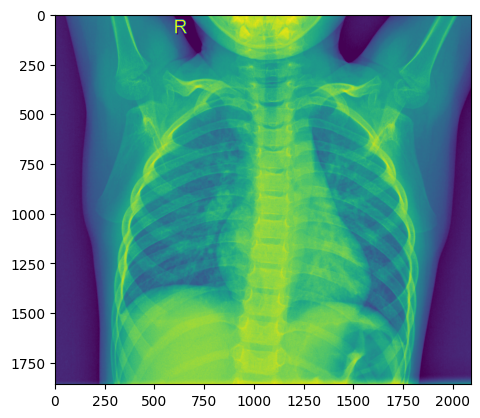

In [11]:
plt.imshow(img)

In [12]:
dimensions = img.shape
print(dimensions)
print('height:',dimensions[0])
print('width:',dimensions[1])

(1858, 2090)
height: 1858
width: 2090


**Task 2:** Let's do some data wrangling and more visualization! [30 Points]

In [13]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [14]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) read the images from directory. create a data array with the dimensions len(all_files)x300x300 and initialize them to zeroes
# TODO: Operation 2) if image dimension>2 convert the rgb image to grayscale. resize images to 300x300
# TODO: Operation 3) it assigns the resized image data to the corresponding index in data array which we initialized with zeroes previously.

In [15]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

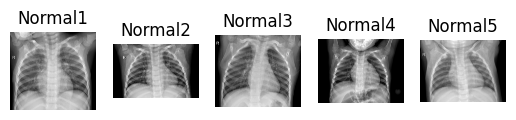

In [16]:
# TODO: YOUR CODE
import os

all_files_in_normal = os.listdir('/content/normal')

for i in range(5):
  image_path = os.path.join('/content/normal', all_files_in_normal[i])
  loaded_image = mh.imread(image_path)
  plt.subplot(1, 5, i+1)
  plt.imshow(loaded_image, cmap='gray')  # Assuming the images are grayscale
  plt.axis('off')
  plt.title('Normal{}'.format(i+1))
plt.show()


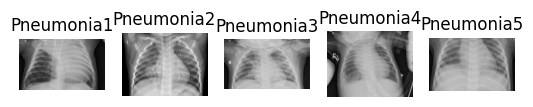

In [17]:
all_files_in_pneumonia = os.listdir('/content/pneumonia')
for i in range(5):
  image_path = os.path.join('/content/pneumonia', all_files_in_pneumonia[i])
  loaded_image = mh.imread(image_path)
  plt.subplot(1, 5, i+1)
  plt.imshow(loaded_image, cmap='gray')  # Assuming the images are grayscale
  plt.axis('off')
  plt.title('Pneumonia{}'.format(i+1))
plt.show()

**Task 3:** Setup training and testing data. [15 Points]

In [18]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [19]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [20]:
# TODO: Please create the y_train vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.

y_train = np.zeros( (TRAINING_COUNT * 3), dtype=np.int32)
t_pos = 0
for i in range(3):
  for j in range(TRAINING_COUNT):
    y_train[t_pos]=i
    t_pos+=1

print(len(y_train))

180


In [21]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[TRAINING_COUNT:TRAINING_COUNT+TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1


In [22]:
# TODO: Please create the y_test vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.zeros( (TESTING_COUNT * 3), dtype=np.int32)
t_pos = 0
for i in range(3):
  for j in range(TESTING_COUNT):
    y_test[t_pos]=i
    t_pos+=1

print(len(y_test))

120


**Task 4:** Let's train and evaluate the Random Forest! [30 Points]

In [23]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [24]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [25]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [26]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [27]:
# TODO: YOUR ANSWER
# Random Forest is built upon decision trees.
# It consists of nodes where each internal node corresponds to a condition on attribute and leaf nodes contain the output labels.
# The branches lead to various labels based on the path followed on evaluation conditions on internal nodes.
# Random forest is a collection of decision trees where the data is divided into subsets randomly using bootstrapping and each subset is given to a decision tree.
# when a new instance is given, all the decision trees predict the label of this instance and the majority label is assigned to the new data point.


In [28]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

0.9333333333333333

In [29]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [30]:
# TODO: YOUR ANSWER
# output 1.0 indicated that the accuracy is 100% which is good.
# It is surprising that the model predicted all the instance labels correctly.
# This may be due to small size of data or may be due to overfitting.
# There is a possibility that the model might not perform well on unseen data

**Task 5:** Now, let's decrease the number of trees! [10 Points]

In [31]:
# How many trees are used in Task 4?

In [32]:
# TODO: YOUR ANSWER
print("no.of trees:",clf.n_estimators)

no.of trees: 100


In [33]:
# Now, please use a single tree and observe the testing performance.

In [34]:
# TODO: YOUR CODE
clf_1 = RandomForestClassifier(n_estimators=1)
fitted = clf_1.fit( X_train, y_train )

In [35]:
clf_1.score( X_test, y_test )

0.6666666666666666

In [36]:
# Are you surprised?

In [37]:
# TODO: YOUR ANSWER
# The output score indicates that the model achieved 66% accuracy in predicting class labels for test data
# This is surprising that the no.of trees used has significant impact on the performance of model. It reduced the accuracy drastically.

**Bonus:** Let's take a closer look! [33 Points]

In [38]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [39]:
# TODO: YOUR CODE AND YOUR ANSWER

X_test_new = np.zeros(( 99, 300*300 ), dtype=np.float32)
t_pos = 0

print(X_test_new.shape)
for d in data[2:]:
  for image in d[100:]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test_new[t_pos] = image
    t_pos += 1

(99, 90000)


In [40]:
y_test_new=np.full(99, 2)

In [41]:
y_pred=clf.predict(X_test_new)

In [42]:
clf.score( X_test_new, y_test_new)

0.9393939393939394

In [43]:
print(y_pred)

[2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2]


In [44]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

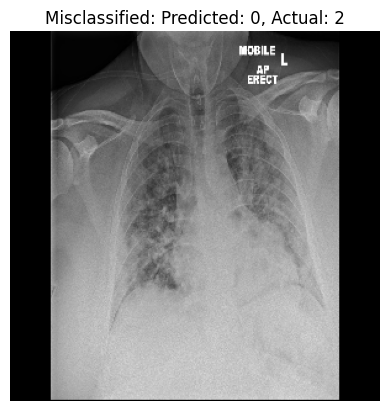

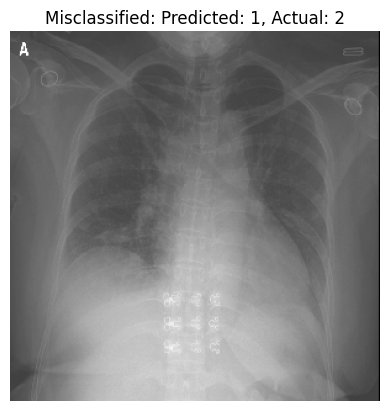

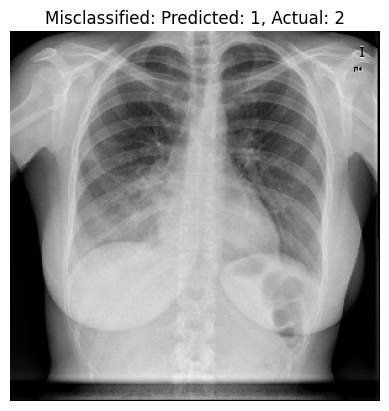

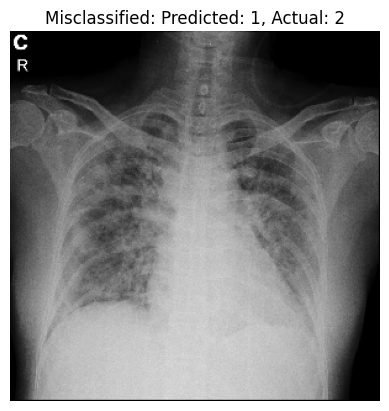

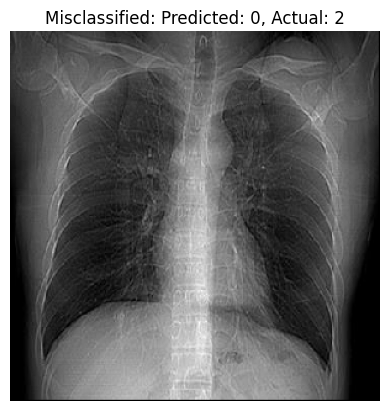

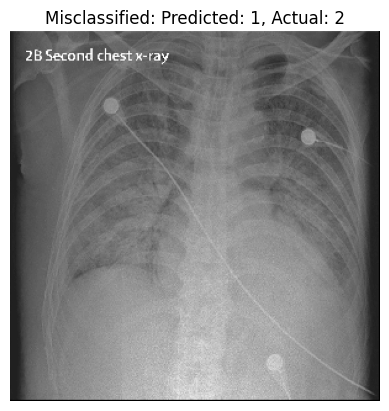

In [45]:
misclassified_indices = np.where(y_pred != y_test_new)[0]

# Display misclassified images
for index in misclassified_indices:
    misclassified_image = X_test_new[index].reshape((300, 300))  # Reshape image if necessary
    plt.imshow(misclassified_image, cmap='gray')  # Assuming images are grayscale
    plt.title('Misclassified: Predicted: {}, Actual: {}'.format(y_pred[index], y_test_new[index]))
    plt.axis('off')
    plt.show()

In [46]:
# the images are problematic because some are blur and some images had noise and are not clear

In [55]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw